# Predicting Future Crime Rates with Facebook Prophet 

## 78753

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

plt.style.use("classic")
%matplotlib inline

In [16]:
# loading datasets
df = pd.read_csv("df_53.csv")

In [17]:
# data cleaning and indexing
drop = ["latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date = df.occurred_date.astype("datetime64")
df.set_index(["occurred_date"], inplace=True)
df.sort_index(inplace=True)

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


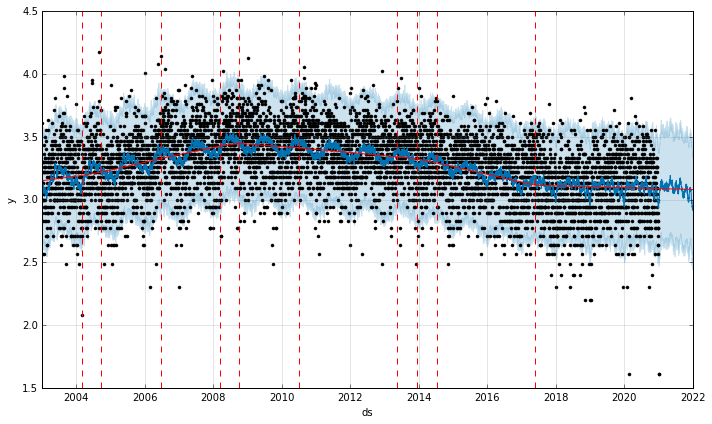

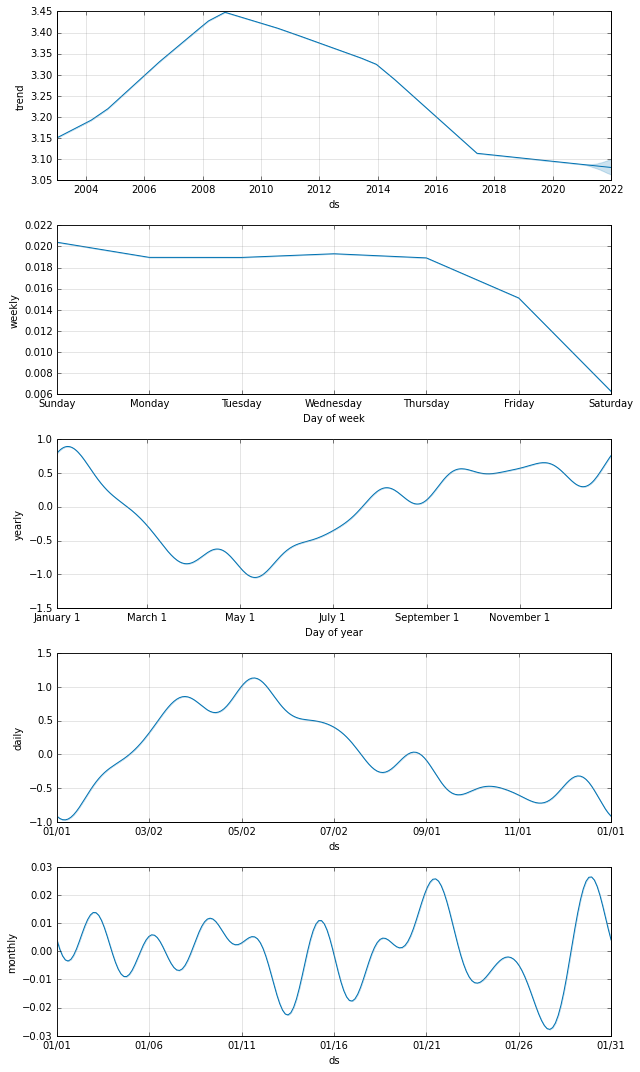

In [18]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
df_m_final["y"] = np.log(df_m_final["y"])
# df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=365, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=365, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [19]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error 
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

711.67

### Mitigating outlier effects on moodel accuracy 

In [20]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

Above 3 standard deviations:  4 entries
Below 3 standard deviations:  20 entries


c:\users\robert\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

c:\users\robert\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


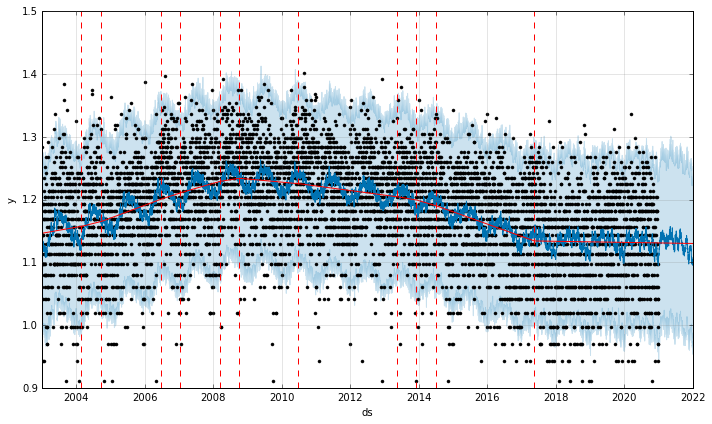

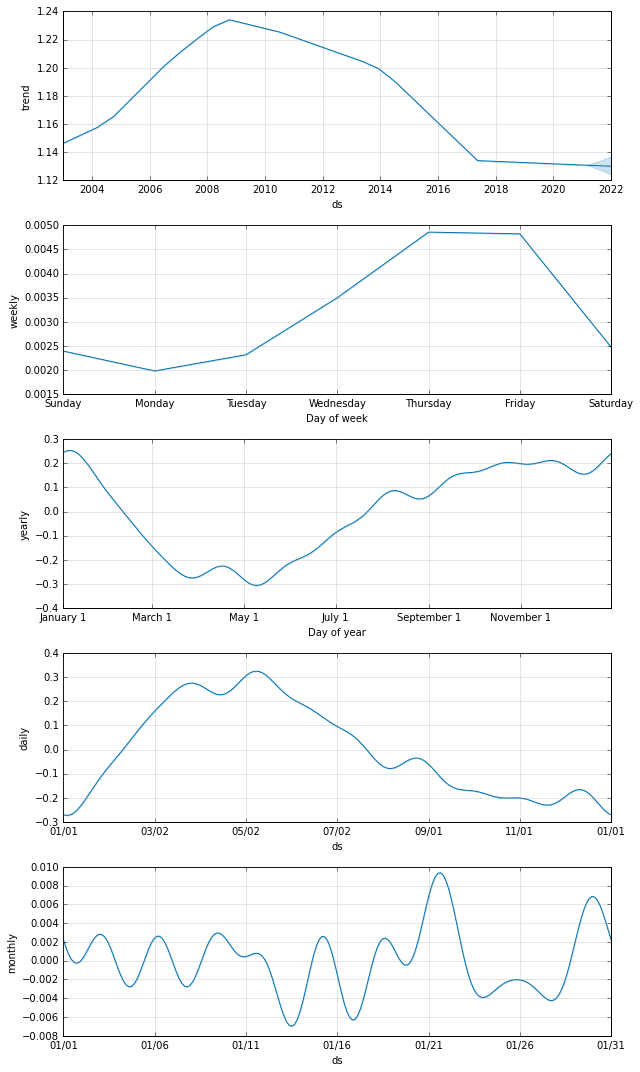

In [21]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
df_prophet2["y"] = np.log(df_prophet2["y"])
# df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=365, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=365)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [23]:
forecast_m2

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2003-01-01  1.146385    0.986211    1.276481     1.146385     1.146385   
1    2003-01-02  1.146411    0.999201    1.261029     1.146411     1.146411   
2    2003-01-03  1.146437    1.003965    1.266585     1.146437     1.146437   
3    2003-01-04  1.146463    0.992797    1.272183     1.146463     1.146463   
4    2003-01-05  1.146489    1.002389    1.273982     1.146489     1.146489   
...         ...       ...         ...         ...          ...          ...   
6936 2021-12-28  1.130084    0.974650    1.231844     1.124300     1.136871   
6937 2021-12-29  1.130082    0.965246    1.227321     1.124279     1.136888   
6938 2021-12-30  1.130079    0.961246    1.224377     1.124258     1.136904   
6939 2021-12-31  1.130077    0.963104    1.249742     1.124237     1.136921   
6940 2022-01-01  1.130075    0.964730    1.230312     1.124217     1.136937   

      additive_terms  additive_terms_lower  additive_terms_upper     daily  \
0          -0.015750             -0.015750             -0.015750 -0.253565   
1          -0.013333             -0.013333             -0.013333 -0.258845   
2          -0.016058             -0.016058             -0.016058 -0.263395   
3          -0.017713             -0.017713             -0.017713 -0.267128   
4          -0.011818             -0.011818             -0.011818 -0.269971   
...              ...                   ...                   ...       ...   
6936       -0.034304             -0.034304             -0.034304 -0.258845   
6937       -0.034550             -0.034550             -0.034550 -0.263395   
6938       -0.030107             -0.030107             -0.030107 -0.267128   
6939       -0.027746             -0.027746             -0.027746 -0.269971   
6940       -0.029088             -0.029088             -0.029088 -0.271864   

      ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     ... -0.005302     -0.005302     -0.005302  0.242698      0.242698   
1     ... -0.001476     -0.001476     -0.001476  0.246367      0.246367   
2     ...  0.002325      0.002325      0.002325  0.249258      0.249258   
3     ...  0.004466      0.004466      0.004466  0.251313      0.251313   
4     ...  0.004633      0.004633      0.004633  0.252489      0.252489   
...   ...       ...           ...           ...       ...           ...   
6936  ...  0.002318      0.002318      0.002318  0.223366      0.223366   
6937  ...  0.003499      0.003499      0.003499  0.229222      0.229222   
6938  ...  0.004858      0.004858      0.004858  0.234626      0.234626   
6939  ...  0.004822      0.004822      0.004822  0.239478      0.239478   
6940  ...  0.002477      0.002477      0.002477  0.243684      0.243684   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0         0.242698                   0.0                         0.0   
1         0.246367                   0.0                         0.0   
2         0.249258                   0.0                         0.0   
3         0.251313                   0.0                         0.0   
4         0.252489                   0.0                         0.0   
...            ...                   ...                         ...   
6936      0.223366                   0.0                         0.0   
6937      0.229222                   0.0                         0.0   
6938      0.234626                   0.0                         0.0   
6939      0.239478                   0.0                         0.0   
6940      0.243684                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  1.130634  
1                            0.0  1.133078  
2                            0.0  1.130378  
3                            0.0  1.128749  
4                            0.0  1.134670  
...                          ...       ...  
6936                         0.0  1.095780  
6

In [22]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

5.65